In [1]:
%load_ext autoreload
%autoreload 2
## driftmlp is the package implementing this methodology
import driftmlp
## h3 to convert locations to their h3 indices.
## Where possible we use driftmlp.helpers.return_h3_inds()
h3_sys = driftmlp.drifter_indexing.discrete_system.DefaultSystem

## core python packages
import os
import numpy as np 
import pickle
import pandas as pd


## Matplotlib for plotting
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import matplotlib.pyplot as plt

## Cartopy for map projections
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import seaborn as sns



## geopandas for aid storing Polygons and plotting
import geopandas as gpd
from shapely.geometry import Polygon


import string
alphabet = string.ascii_lowercase


driftfile = os.environ['DRIFTFILE'] 
### Generated by MakeDefNetworks
networks = pickle.load(open('default_networks.p', 'rb'))

### Only use drogued drifters
network = networks[True]
driftmlp.helpers.remove_undesired(network)
postfix = 'drg'
del networks

### Our example locations are in locations.txt
stations = np.loadtxt("locations.txt", delimiter=',')
stations = pd.DataFrame(stations, index=range(1, 8))
stations.columns = ['Longitude', 'Latitude']
stations['h3'] = h3_sys.return_inds([i[['Longitude', 'Latitude']].to_list() for _,i in stations.iterrows()])
stations.loc[:,['Longitude', 'Latitude']].to_latex()
print(sum([1 if len(i)>0 else 0 for i in network['stories']]))


23461


In [2]:
def add_travel_time_edge(edge):
    tt = driftmlp.shortest_path.travel_time(network, edge.source, edge.target)
    edge['Travel_Time'] = tt
    return tt
all_tt =[add_travel_time_edge(edge) for edge in network.es]

In [3]:
crs = ccrs.Robinson()

def cuts2poly(lon_left, lon_right, lat_bottom, lat_top):
    return Polygon(np.array([(lon_left, lat_bottom), (lon_right, lat_bottom),
                             (lon_right, lat_top), (lon_left, lat_top)]))

def return_travel_time_df(h3_ind,get_return=True):
    lon_len, lat_len=145, 73
    #lon_len, lat_len = 181, 91
    lon_ranges = np.linspace(-180, 180, lon_len)
    lat_ranges = np.linspace(-90, 90, lat_len)

    poly_limits = [(lon_ranges[i],
                    lon_ranges[i+1],
                    lat_ranges[j], lat_ranges[j+1])
                   for i in range(len(lon_ranges)-1)
                   for j in range(len(lat_ranges)-1)]

    poly_centers = [((i[1]+i[0])/2, (i[3]+i[2])/2) for i in poly_limits]

    h3_centers = h3_sys.return_inds(poly_centers)

    polygons = [cuts2poly(*poly_limit) for poly_limit in poly_limits]

    all_paths_away = driftmlp.shortest_path.get_all_paths(network, h3_ind, h3_centers, weight='Travel_Time')
    
    
    tts = [path.travel_time/365 for path in all_paths_away]
  
    plot_data = gpd.GeoDataFrame({'geometry': polygons, 'traveltime': tts}, crs=None)
    ## Drop land polygons, and non accesible polygons.

#    plot_data['traveltime'] = plot_data.loc[:,'traveltime']/365
    if get_return:
        all_paths_into = [driftmlp.shortest_path.network_path(network, h3_center, h3_ind, weight='Travel_Time') for h3_center in h3_centers]
        tts_return = [path.travel_time/365 for path in all_paths_into]
        plot_data['incoming_traveltime'] = tts_return
    return plot_data


point1 = -160.449222,29.529525
point2 = 30.462885, -32.634840 
h3_ind1 = h3_sys(lon=point1[0], lat=point1[1])
h3_ind2 = h3_sys(lon=point2[0], lat=point2[1])
travel_times_df1=return_travel_time_df(h3_ind1)
travel_times_df2=return_travel_time_df(h3_ind2)

/home/omalley3/Docs/DriftMLP/driftmlp/shortest_path/__init__.py:73: RuntimeWarning: Couldn't reach some vertices at ../../../source/igraph/src/structural_properties.c:4745
  sps = network.get_shortest_paths(from_node, to_nodes, weights=weight)
/home/omalley3/Docs/DriftMLP/driftmlp/shortest_path/__init__.py:40: RuntimeWarning: Couldn't reach some vertices at ../../../source/igraph/src/structural_properties.c:4745
  all_sp = network.get_shortest_paths(node_from, node_to, weights=weight)


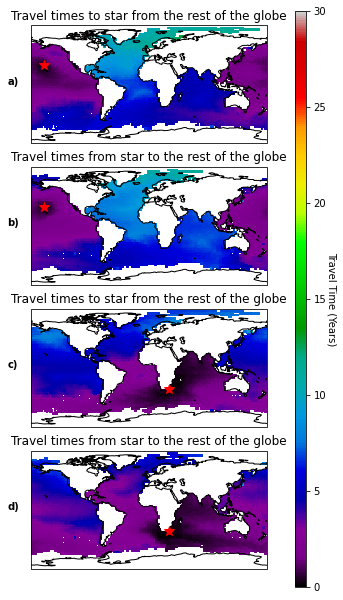

In [9]:
## Color bar settings
crs = ccrs.PlateCarree()
fig, axs = plt.subplots(4, 1, subplot_kw={'projection': crs},
                        figsize=(5.5, 10))
norm = plt.Normalize(vmin =0, vmax=30)
#norm.autoscale(travel_times_df1['traveltime'])
cmap = plt.get_cmap('nipy_spectral')
def plot_travel_time_df(travel_time_df, norm, ax,col = 'traveltime',
                       source=[0,0]):

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)





    # Make the CartoPy plot by adding the polygons colored by the travel time
    plot_df = travel_time_df.query(f"{col}>0")
    for color, rows in plot_df.groupby(col):
        color_mapped = sm.cmap(norm(color))
        ax.add_geometries(rows['geometry'], crs=ccrs.PlateCarree(),
                           facecolor=color_mapped, edgecolor=color_mapped)
    ax.coastlines()
    #q = ax.get_extent()
    
    
    
    ax.plot(source[0], source[1], '*',
             color='red', markersize=10, transform=ccrs.Geodetic())
    ax.set_global()
    
    
plot_travel_time_df(travel_times_df1, norm, axs[1], source=point1)
axs[1].set_title("Travel times from star to the rest of the globe")
plot_travel_time_df(travel_times_df1, norm, axs[0], col='incoming_traveltime', source=point1)
axs[0].set_title("Travel times to star from the rest of the globe")
plot_travel_time_df(travel_times_df2, norm, axs[3], source=point2)
axs[3].set_title("Travel times from star to the rest of the globe")
plot_travel_time_df(travel_times_df2, norm, axs[2], col='incoming_traveltime', source=point2)
axs[2].set_title("Travel times to star from the rest of the globe")
for i in range(4):
    plot_num = alphabet[i]
    axs[i].text(-0.1,0.5,"{})".format(plot_num),transform = axs[i].transAxes, fontweight='bold')

cax = fig.add_axes([0.88, 0.1, 0.03, 0.8])  # x0 y0 width height

cbar = mpl.colorbar.ColorbarBase(cax,
                          cmap=cmap,
                          norm=norm)
cbar.set_label('Travel Time (Years)', rotation=270,labelpad=10)
fig.savefig(f"Images/tt_short_{postfix}.png", bbox_inches='tight')
fig.savefig(f"Images/tt1_short_{postfix}.pdf", bbox_inches='tight')